# Damage function formulation within a thermodynamic material model

The notebook shows how to construct a damage function as an evolution law within a time-stepping inelastic algorithm which
 - implicitly approaches the value 1 in a limit
 - has a desirebed algebraic shape with specified material parameters
 - can support self-regularization in terms of a fracture energy parameter
   which controls the integral of the stress-strain response. 

In [1]:
%matplotlib widget
import sympy as sp
import numpy as np
import matplotlib.pylab as plt
sp.init_printing()

# Self-regularized softening function

Let us consider a softening function of the form
\begin{align}
f(w) = c_1 exp( - c_2 w )
\end{align}
This is function should describe the decay of stress starting from the material tensile strength and continuously deminishing to zero.
The variable $w$ represents the crack opening and the parameters $c_1$ and $c_2$ are the material parameters.

In [2]:
w = sp.symbols('w')
c_1 = sp.symbols('c_1')
c_2 = sp.symbols('c_2')

In [3]:
f_w = c_1 * sp.exp(-c_2*w)
f_w

Let us plot the function to verify its shape for the material parameters set to the value 1

In [4]:
w_arr = np.linspace(0.01,10,100)
fig, ax = plt.subplots(1,1,figsize=(5,3), tight_layout=True)
ax.plot(w_arr, sp.lambdify((w, c_1, c_2), f_w)(w_arr,1,1));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The function can be already used in this form. The question is however, how to set the material parameters $c_1$ and $c_2$. They can be directly associated to a particular type of material parameters - namely, to the tensile strength $f_\mathrm{t}$ and fracture energy $G_\mathrm{f}$ 

In [5]:
f_t, G_f = sp.symbols('f_t, G_f', positive=True)

Softening starts at the level of the material strength so that we can set $f(w = 0) = f_\mathrm{t}$  to obtain the equation

In [6]:
Eq1 = sp.Eq( f_w.subs({'w':0}), f_t)
Eq1

By solving for the $c_1$ we obtain the first substitution for our softening function.

In [7]:
c_1_subs = sp.solve({Eq1}, c_1)
c_1_subs

Thus, if $w_0 = 0$, $c_1$ is equivalent to the tensile strength $f_\mathrm{t}$

The second possible mechanical interpretation is provided by the statement that softening directly represents the energy dissipation of a unit crack area. Thus, for large $w \rightarrow \infty$ it is equivalent to the energy producing a stress-free crack. This is the meaning of fracture energy.

We can thus obtain the fracture energy represented by the softening function by evaluating its integral in the range $w \in (0, \infty)$. 

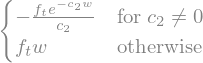

In [8]:
int_f_w = sp.integrate(f_w.subs(c_1_subs), w)
int_f_w

As $c_2 > 0$, only the second term matters.
The determinate integral
\begin{align}
\left[ - \frac{f_\mathrm{t}}{c_2} 
\exp(-c_2 w) \right]_0^{\infty}
\end{align}
is zero for $w = \infty$, so that the value in $w = 0$ delivers the result of the integral
\begin{align}
\frac{f_\mathrm{t}}{c_2} 
\end{align}

This integral is equal to the fracture energy $G_\mathrm{f}$.

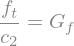

In [9]:
Eq2 = sp.Eq(-int_f_w.args[0][0].subs({'w':0}), G_f)
Eq2

and the value of $c_2$ delivers the second substitution for the softening function

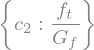

In [10]:
c_2_subs = sp.solve({Eq2}, c_2)
c_2_subs

The softening function with strength and fracture energy as a parameter now obtains the form

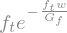

In [11]:
f_w_solved = f_w.subs(c_1_subs).subs(c_2_subs)
sp.simplify(f_w_solved)

Verify that the fracture energy is recovered at $w$ in infinity

In [12]:
sp.integrate(f_w_solved, (w,0,sp.oo))

The above derivation consideres a purely inelastic range 
and 

# Self regularized damage function

In [328]:
r = sp.symbols(r'r', positive=True)
E_ = sp.symbols(r'E', positive=True)
u = sp.symbols(r'u')
omega = sp.Function(r'omega')
G_ = sp.symbols(r'G_f', positive=True)
C2 = sp.symbols(r'C_2', positive=True)
C3 = sp.symbols(r'C_3', positive=True)
c = sp.symbols(r'c', positive=True)

In [329]:
Y = sp.Rational(1,2) * E_ * u**2  # N/m^2 m^2 - N

Inclusion of Y in the damage function is 
necessary to recover the G_F via \int Y \dot{omega} and \int \sigma u 

In [330]:
lam = sp.symbols(r'\lambda', positive=True)

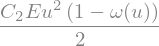

In [355]:
dot_omega_u_r = ((1 - omega(u))**(1) * ((C2 * Y)**r)) # lambda N^r m^2
dot_omega_u = dot_omega_u_r.subs(r,1) # 1/m = m * C2 * N    !  C2 = 1/(Nm^2)
dot_omega_u

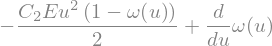

In [356]:
omega_evol_law = sp.Derivative(omega(u), u) - dot_omega_u
omega_evol_law

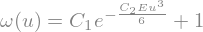

In [357]:
omega_u_eq = sp.dsolve(omega_evol_law, omega(u))
omega_u_eq

In [358]:
omega_u = omega_u_eq.args[1]
omega_u

In [359]:
C1_solved = sp.solve(omega_u.subs(u,0), 'C1')[0] # check the elastic range
C1_solved

In [360]:
omega_u_C2 = omega_u.subs('C1', C1_solved)
omega_u_C2

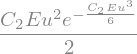

In [362]:
dot_omega_u_C2 = dot_omega_u.subs(omega(u), omega_u_C2)
dot_omega_u_C2

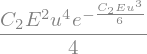

In [363]:
dot_G = Y * dot_omega_u_C2
dot_G   # Nm/m = Y 

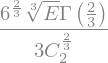

In [364]:
G_F = sp.integrate(dot_G, (u,0,sp.oo))
G_F # N/m^2 * (1/sqrt(m))^2 = N / m 

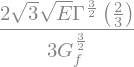

In [365]:
C2_solved = sp.solve(sp.Eq( G_, G_F ),  C2)[0]
sp.simplify(C2_solved)      # sqrt(N/m^2 / N/m)  = 1 / sqrt(m)

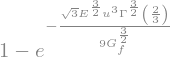

In [292]:
omega_u_solved = omega_u_C2.subs(C2, C2_solved)
sp.simplify(omega_u_solved) 

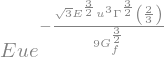

In [293]:
sigma_u = ( 1 - omega_u_solved ) * E_ * u
sigma_u

In [294]:
sp.integrate(sigma_u, (u,0,sp.oo))

In [295]:
u_argmax = sp.solve(sigma_u.diff(u),u)[0]

In [296]:
sig_max = sp.simplify(sigma_u.subs(u, u_argmax))

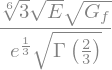

In [297]:
sig_max

In [319]:
psi_u_norm = sp.simplify((1 - omega_u_solved) / sig_max)
omega_u_norm = sp.simplify(1 - psi_u_norm)

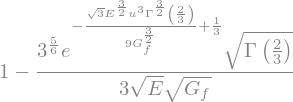

In [325]:
omega_u_norm

In [326]:
get_sigma_u_ = sp.lambdify((u, E_, G_), sigma_u)
get_omega_u_ = sp.lambdify((u, E_, G_), omega_u_solved)
get_sig_u_norm_ = sp.lambdify((u, E_, G_), (1 - omega_u_norm) * E_ *u )

In [327]:
_, ax = plt.subplots(1,1)
ax2 = ax.twinx()
u_range = np.linspace(0,20,200)
w_range = u_range
E_value, G_value = 10000, 40000
# ax.plot(u_range, get_sigma_u_(u_range,E_value,G_value), label='f(u)')
# ax2.plot(u_range, get_omega_u_(u_range,E_value,G_value), color='red');
ax2.plot(u_range, get_sig_u_norm_(u_range,E_value,G_value), color='red');
ax.legend();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No handles with labels found to put in legend.


In [324]:
w = sp.symbols(r'w')
w_0 = sp.symbols(r'w_0', positive=True)

In [79]:
omega_w = sp.Piecewise( (0, w < w_0),
                        (omega_u_solved.subs(u, w-w_0), True))

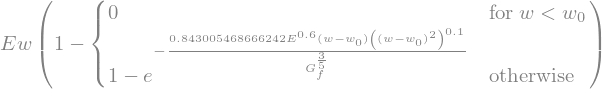

In [80]:
sigma_w = ( 1 - omega_w ) * E_ * w
sigma_w

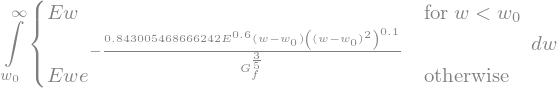

In [81]:
sp.integrate(sigma_w, (w,w_0,sp.oo))

In [82]:
get_sigma_w_ = sp.lambdify((w, w_0, E_, G_), sigma_w)
get_omega_w_ = sp.lambdify((w, w_0, E_, G_), omega_w)

In [83]:
_, ax = plt.subplots(1,1)
ax2 = ax.twinx()
w_range = np.linspace(0,20,100)
w_0_value, E_value, G_value = 2.5, 1000, 40000
ax.plot(w_range, get_sigma_w_(w_range, w_0_value, E_value,G_value), label='f(u)')
ax2.plot(w_range, get_omega_w_(w_range, w_0_value, E_value,G_value), color='red');
ax.legend();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

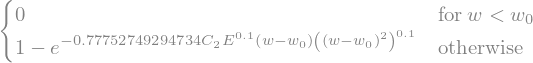

In [84]:
omega_w_C2 = sp.Piecewise((0, w < w_0),
                               (omega_u_C2.subs(u, w-w_0), True))
omega_w_C2

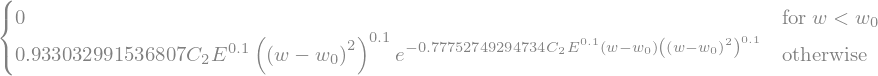

In [85]:
dot_omega_w_C2 = sp.Piecewise((0, w < w_0),
                               (dot_omega_u_C2.subs(u, w-w_0), True))
dot_omega_w_C2

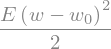

In [86]:
Y_w = Y.subs(u, w-w_0)
Y_w

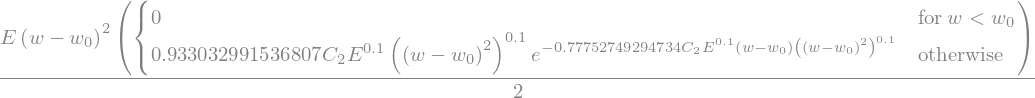

In [87]:
dot_G_w = Y_w * dot_omega_w_C2
dot_G_w

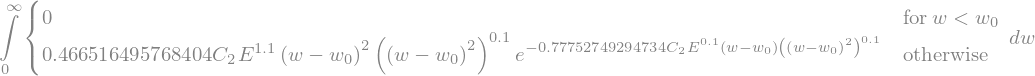

In [88]:
G_F_w_Y = sp.integrate(dot_G_w, (w,0,sp.oo)) # - Y_0
G_F_w_Y

In [89]:
C2_Y_solved = sp.solve(sp.Eq( G_, G_F_w_Y ),  C2)[0]
sp.simplify(C2_Y_solved)

IndexError: list index out of range

In [ ]:
omega_w_Y_solved = omega_w_C2.subs(C2, C2_Y_solved)
sp.simplify(omega_w_Y_solved)

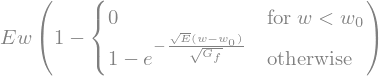

In [90]:
sigma_w_Y = ( 1 - omega_w_Y_solved ) * E_ * w
sigma_w_Y

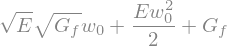

In [91]:
sp.simplify(sp.integrate(sigma_w_Y, (w,0,sp.oo)))

**Conclusion:** After including elastic behavior, there is a discrepancy between $\int Y\dot{\omega} \, \mathrm{d}u$ and $\int \sigma(u)\, \mathrm{d}u$

# Derive the the fracture energy on a $\sigma, w$ scale 

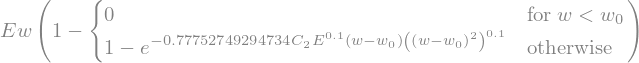

In [92]:
sigma_w_C2 = ( 1 - omega_w_C2 ) * E_ * w
sigma_w_C2

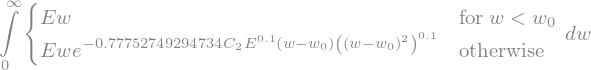

In [93]:
G_F_w_sig = sp.integrate( sigma_w_C2, (w,0,sp.oo))
G_F_w_sig

In [94]:
C2_sig_solved = sp.solve(sp.Eq( G_, G_F_w_sig ),  C2)[1]
C2_sig_solved

IndexError: list index out of range

In [ ]:
sigma_w_Gf = sigma_w_C2.subs(C2, C2_sig_solved)
sigma_w_Gf

In [ ]:
w_argmax = sp.solve(sigma_w_Gf.diff(w), w)[0].args[0].args[0]
w_argmax

In [ ]:
sigma_max = sigma_w_Gf.subs(w, w_argmax)
sigma_max

In [ ]:
get_sigma_w_Gf = sp.lambdify((w, w_0, E_, G_), sigma_w_Gf)
get_w_argmax = sp.lambdify((w_0, E_, G_), w_argmax)
get_sigma_max = sp.lambdify((w_0, E_, G_), sigma_max)

In [ ]:
_, ax = plt.subplots(1,1)
ax2 = ax.twinx()
w_range = np.linspace(0,200,100)
w_0_value, E_value, G_value = 1.5, 1000, 400000
ax.plot(w_range, get_sigma_w_Gf(w_range, w_0_value, E_value, G_value), label='f(u)')
w_00 = get_w_argmax(w_0_value, E_value, G_value)
sigma_00 = get_sigma_max(w_0_value, E_value, G_value)
ax.plot([w_00], [sigma_00], marker='o', color='green')
ax.plot([w_0_value], [get_sigma_w_Gf(w_0_value, w_0_value, E_value, G_value )], marker='o', color='red')
#ax2.plot(w_range, get_omega_w_(w_range, w_0_value, E_value,G_value), color='red');
ax.legend();

# Isolating damage energy dissipation

In [375]:
from sympy import Function, dsolve, Eq, Derivative, symbols
u_p = sp.symbols(r'u_p')
Y = sp.symbols(r'Y')
sigma = sp.symbols(r'\sigma')
lambda_ = sp.symbols(r'\lambda', nonnegative=True)
sigma_eff = sp.symbols(r'\sigma_\mathrm{eff}')
bar_sigma = sp.symbols(r'\bar{\sigma}')
#f_0 = sp.symbols(r'f_0', positive=True)
omega_u = Function('omega')
omega_ = sp.symbols(r'omega', positive=True)
#S_ = sp.symbols(r'S', positive=True)
c_ = sp.symbols(r'c', positive=True)

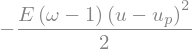

In [376]:
psi_rho = sp.simplify(sp.Rational(1,2) * (1 - omega_) * E_ * (u - u_p)**2)
psi_rho

In [377]:
sigma_ = sp.simplify(psi_rho.diff(u))
sigma_p_ = sigma_
sigma_

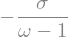

In [378]:
sigma_eff_ = sp.simplify(sigma / (1 - omega_))
sigma_eff_

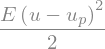

In [379]:
Y_ = -sp.simplify(psi_rho.diff(omega_))
Y_

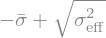

In [380]:
f_ = sp.sqrt(sigma_eff**2) - bar_sigma
#f_ = sp.Abs(sigma_eff) - bar_sigma
f_

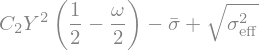

In [381]:
phi_ = f_ + sp.Rational(1,2) * (1 - omega_) * C2 * Y**2
phi_

In [382]:
dot_omega_= lambda_ * sp.simplify(phi_.diff(Y))
dot_omega_

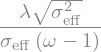

In [383]:
dot_u_p_ = -lambda_ * sp.simplify(phi_.diff(sigma_eff)) * sigma_eff_.diff(sigma)
sp.simplify(dot_u_p_)

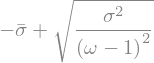

In [384]:
f_Sig_ = f_.subs(sigma_eff, sigma_eff_)
f_Sig_

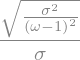

In [385]:
dot_f_Sig_ = sp.simplify(f_Sig_.diff(sigma))
dot_f_Sig_

## Further steps
\begin{align}
 \dot{f} = \frac{\partial f}{\partial \sigma} \dot{\sigma} = 
 \frac{\partial f}{\partial \sigma_\mathrm{eff}} \frac{\partial \sigma_\mathrm{eff}}{\partial \sigma} \dot{\sigma}
\end{align}

 * substitute the constitutive law and the evolution equation and solve
 for $\lambda$
 * substituted $\lambda$ into $\dot{\omega}$
 * evaluate energy dissipation $ Y \dot{\omega} $
 * integrate it for $u$
 * set the result equal to $G_\mathrm{F}$ and resolve $C_2$ for it.

**Note:** this is probably not realistic to achieve. If the solution is not possible, provide a solver to obtain $C_2$ rendering a required $G_\mathrm{F}$ numerically 

# Convert the damage function to a softening function

In [83]:
f_w = f_0 * (1 - omega_u.subs(u,w))
f_w

In [84]:
C1_solved = sp.solve(sp.Eq(f_w.subs(w,0), f_0), 'C1')[0]
C1_solved

In [85]:
f_w_C2 = f_w.subs('C1', C1_solved)
f_w_C2

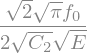

In [86]:
int_f_w_C2 = sp.integrate(f_w_C2, (w,0,sp.oo))
int_f_w_C2

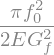

In [87]:
C2_solved = sp.solve(sp.Eq( G_, int_f_w_C2 ),  C2)[0]
sp.simplify(C2_solved)

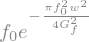

In [89]:
f_w_solved = f_w_C2.subs(C2, C2_solved)
f_w_solved

In [90]:
#get_omega_u = sp.lambdify((u, f_0, G_), omega_u_solved)
get_f_w = sp.lambdify((w, f_0, G_), f_w_solved)

In [91]:
_, ax = plt.subplots(1,1)
ax2 = ax.twinx()
w_range = np.linspace(0,10,100)
ax.plot(w_range, get_f_w(w_range,1,2), label='f(u)')
#ax2.plot(u_range, get_omega_u(u_range,1,10), color='red');
ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

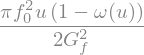

In [92]:
dot_omega_u.subs(C2, C2_solved)